Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Norm of velocity coefficient vector: 29.2586492288133
Norm of pressure coefficient vector: 109.781897106391


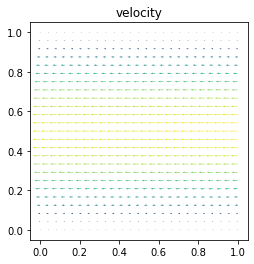

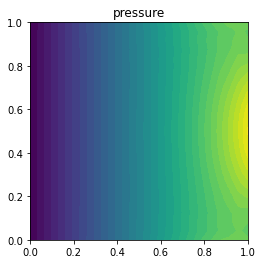

In [5]:
"""This demo solves the Stokes equations, using linear elements
enriched with a bubble for the velocity and linear elements for the
pressure (Mini elements). The sub domains for the different boundary
conditions used in this simulation are computed by the demo program in
src/demo/mesh/subdomains."""

# Copyright (C) 2007 Kristian B. Oelgaard
#
# This file is part of DOLFIN.
#
# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.
#
# Begin demo


import matplotlib.pyplot as plt
from dolfin import *

# Load mesh and subdomains
mesh = UnitSquareMesh(24,24)

# Build function spaces on Mini element
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
B = FiniteElement("Bubble", mesh.ufl_cell(), mesh.topology().dim() + 1)
V = VectorElement(NodalEnrichedElement(P1, B))
Q = P1
W = FunctionSpace(mesh, V * Q)

def right(x, on_boundary): return x[0] > (1.0 - DOLFIN_EPS)
def left(x, on_boundary): return x[0] < DOLFIN_EPS
def top_bottom(x, on_boundary):
    return x[1] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS

# No-slip boundary condition for velocity
bc0 = DirichletBC(W.sub(0), (0, 0),top_bottom)#, sub_domains, 0)

# Inflow boundary condition for velocity
inflow = Expression(("-sin(x[1]*pi)", "0.0"), degree=2)
bc1 = DirichletBC(W.sub(0), inflow,right)#, sub_domains, 1)

# Collect boundary conditions
bcs = [bc0, bc1]

# Define variational problem
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
f = Constant((0, 0))
a = (inner(grad(u), grad(v)) - div(v)*p - q*div(u))*dx
L = inner(f, v)*dx

# Compute solution
w = Function(W)
solve(a == L, w, bcs)

# Split the mixed solution using deepcopy
# (needed for further computation on coefficient vector)
u, p = w.split(True)

print("Norm of velocity coefficient vector: %.15g" % u.vector().norm("l2"))
print("Norm of pressure coefficient vector: %.15g" % p.vector().norm("l2"))

# Split the mixed solution using a shallow copy
u, p = w.split()

# Save solution in VTK format
#ufile_pvd = File("velocity.pvd")
#ufile_pvd << u
#pfile_pvd = File("pressure.pvd")
#pfile_pvd << p

# Plot solution
plt.figure()
plot(u, title="velocity")

plt.figure()
plot(p, title="pressure")

# Display plots
plt.show()